<a href="https://colab.research.google.com/github/kk-shetty/data_science_ik/blob/main/projects/ml_mini_project/node_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Mini Project - **Understanding Networks through Clustering**.
## Leveraging Local Node Features for Structural Profiling

## 1. Data Loading and Library Import

In this section, we import the necessary libraries and load the data into Google Colab from Google Drive. We use the `google.colab.drive` module to access files stored in Google Drive, and the `networkx` and `pandas` libraries for working with network data and data analysis, respectively.


In [1]:
# Importing necessary libraries
from google.colab import drive
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Mounting Google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading edge file
file_url = '/content/drive/My Drive/ml_mini_project_data/soc-karate.txt'
network = nx.read_edgelist(file_url)

In [4]:
# Basic details about the network
print("Number of nodes:", network.number_of_nodes())
print("Number of edges:", network.number_of_edges())

Number of nodes: 34
Number of edges: 78


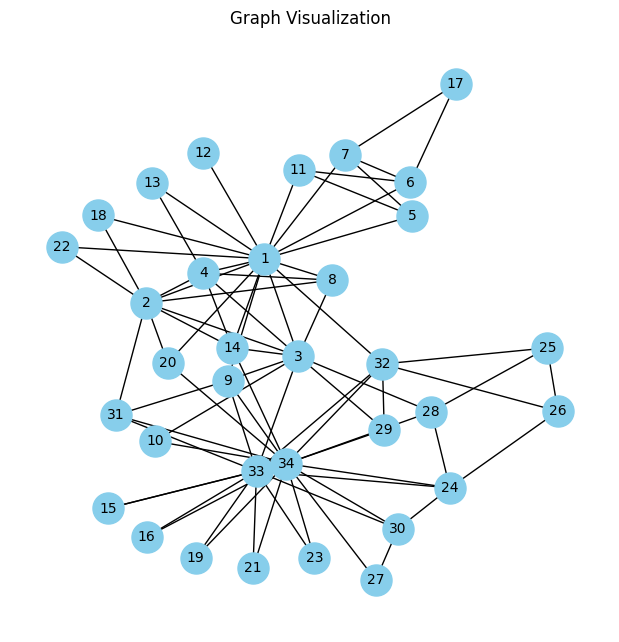

In [5]:
# Plotting the network for visualization
plt.figure(figsize=(6,6))
# pos = nx.fruchterman_reingold_layout(network)
pos = nx.kamada_kawai_layout(network)
# pos = nx.random_layout(network)
nx.draw(network, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='black', linewidths=1, font_size=10)
plt.title("Graph Visualization")
plt.show()

## 2. Extracting Local Features from the Network

In this section, we extract local features for each node in the network up to the fourth ego network (radius = 1 to 4). Local features capture the structural properties of the network neighborhood around each node, providing insights into its immediate connectivity and topology.

### Functions Used:

#### `extract_local_features(local_network, node, radius)`

This function computes various local features for a given node within its ego network of a specified radius. It calculates properties such as clustering coefficient, ego network size, density, number of triangles (closed triangles), number of bridges, centrality properties (radius, diameter, center), cycle basis count, and cycle counts of different lengths up to 6. The function returns a dictionary containing these features.

#### Usage:

We utilize the `extract_local_features` function to extract local features for each node in the network up to the fourth ego network. For each node, we iterate over ego networks of increasing radius, compute the local features using the function, and store the results in a dictionary.

### Steps:

1. **Iterate Over Nodes**: We iterate over each node in the network.
2. **Compute Local Features**: For each node, we compute local features within ego networks of radius 1 to 4 using the `extract_local_features` function.
3. **Create DataFrame**: We construct a pandas DataFrame from the computed local features dictionary, with nodes as rows and features as columns.

### Result:

The resulting DataFrame contains local features for each node, where each row represents a node and each column represents a local feature. This DataFrame serves as the basis for further analysis and modeling tasks, such as clustering nodes based on their structural similarities.

Let's take a sample of 20 rows from the DataFrame to examine the extracted local features.


In [6]:
# Function to extract loac features of each node for different ego network

def extract_local_fetures(local_network, node, radius):

    features = {}
    cycle_counts = {4:0, 5:0, 6:0}

    # calculate clustering coefficient only for first ego network
    if radius==1:
        features['node_clustering_coefficient'] = nx.clustering(local_network, node)

    # Ego netwrok properties
    features[f'EN{radius}_number_of_nodes'] = local_network.number_of_nodes()
    features[f'EN{radius}_number_of_edges'] = local_network.number_of_edges()
    features[f'EN{radius}_ego_density'] = nx.density(local_network)

    # Number of Triads (Closed traiangles)
    features[f'EN{radius}_triangles_count'] = sum(nx.triangles(local_network).values())//3

    # Number of bridges
    features[f'EN{radius}_bridges_count']= len([b for b in nx.bridges(local_network)])

    # Actual radius, diameter and center based on local network
    if node in nx.center(local_network):
        features[f'EN{radius}_is_center'] = 1
    else:
        features[f'EN{radius}_is_center'] = 0
    features[f'EN{radius}_radius'] = nx.radius(local_network)
    features[f'EN{radius}_diameter'] = nx.diameter(local_network)

    # Count of cycle basis and nax length of cycle basis
    cycle_basis_lengths = [len(cycle) for cycle in nx.cycle_basis(local_network)]
    features[f'EN{radius}_cycle_basis_count'] = len(cycle_basis_lengths)
    if len(cycle_basis_lengths):
        features[f'EN{radius}_max_cycle_basis'] = max(cycle_basis_lengths)
    else:
        features[f'EN{radius}_max_cycle_basis'] = 0

    # Cycle counts of different length till 6
    for cycle in nx.simple_cycles(local_network, length_bound=6):
        if len(cycle) > 3:
            cycle_counts[len(cycle)] += 1

    for length, count in cycle_counts.items():
        features[f'EN{radius}_cycle_of_{length}'] = count

    return features

In [7]:
# Using the above function to extract the local featrures upto 4 ego network and creating a data frame using all the fgeatures as columns.

local_features = {}
for node in network.nodes():
    local_features[node] = {}
    for radius in range(1,5):
        # Creating ego graph for the selected node
        ego_network = nx.ego_graph(network, node, radius=radius)
        local_features[node].update(extract_local_fetures(ego_network, node, radius))


In [14]:
# Creating pandas dataframe from the features dictionary
df = pd.DataFrame.from_dict(local_features, orient='index')
df.index.name = 'node'
df.reset_index(inplace=True)
df.sample(20)

,node,node_clustering_coefficient,EN1_number_of_nodes,EN1_number_of_edges,EN1_ego_density,EN1_triangles_count,EN1_bridges_count,EN1_is_center,EN1_radius,EN1_diameter,...,EN4_triangles_count,EN4_bridges_count,EN4_is_center,EN4_radius,EN4_diameter,EN4_cycle_basis_count,EN4_max_cycle_basis,EN4_cycle_of_4,EN4_cycle_of_5,EN4_cycle_of_6
25,16,1.000000,3,3,1.000000,1,0,1,1,1,...,44,1,0,2,4,44,6,153,371,966
6,7,0.500000,5,7,0.700000,3,0,1,1,2,...,45,1,0,3,5,45,6,154,374,969
5,6,0.500000,5,7,0.700000,3,0,1,1,2,...,45,1,0,3,5,45,6,154,374,969
29,26,0.333333,4,4,0.666667,1,1,1,1,2,...,45,1,0,3,5,45,6,154,374,969
1,1,0.150000,17,34,0.250000,25,2,1,1,2,...,45,1,1,3,5,45,6,154,374,969
13,18,1.000000,3,3,1.000000,1,0,1,1,1,...,45,1,0,3,5,45,6,154,374,969
19,28,0.166667,5,5,0.500000,1,2,1,1,2,...,45,1,0,3,5,45,6,154,374,969
15,22,1.000000,3,3,1.000000,1,0,1,1,1,...,45,1,0,3,5,45,6,154,374,969
24,15,1.000000,3,3,1.000000,1,0,1,1,1,...,44,1,0,2,4,44,6,153,371,966
3,4,0.666667,7,16,0.761905,17,0,1,1,2,...,45,1,1,3,5,45,6,154,374,969


## 3. Feature Engineering

In [15]:
# Checking unque values for each of the features
df.nunique()

node                           34
node_clustering_coefficient    13
EN1_number_of_nodes            11
EN1_number_of_edges            15
EN1_ego_density                15
EN1_triangles_count            13
EN1_bridges_count               4
EN1_is_center                   1
EN1_radius                      1
EN1_diameter                    2
EN1_cycle_basis_count          13
EN1_max_cycle_basis             2
EN1_cycle_of_4                 13
EN1_cycle_of_5                 10
EN1_cycle_of_6                  8
EN2_number_of_nodes            14
EN2_number_of_edges            18
EN2_ego_density                18
EN2_triangles_count            17
EN2_bridges_count               4
EN2_is_center                   2
EN2_radius                      2
EN2_diameter                    3
EN2_cycle_basis_count          15
EN2_max_cycle_basis             4
EN2_cycle_of_4                 20
EN2_cycle_of_5                 20
EN2_cycle_of_6                 20
EN3_number_of_nodes             6
EN3_number_of_

In [31]:
# Let's remove feature with constant values
columns_to_drop = ['EN1_is_center', 'EN1_radius', 'EN4_bridges_count']
# df.drop(columns=['EN1_is_center', 'EN1_radius', 'EN4_bridges_count'], inplace=True)

In [35]:
# Value counts of features with low variance
df[['EN1_max_cycle_basis', 'EN1_max_cycle_basis', 'EN2_is_center', 'EN2_radius', 'EN2_diameter', 'EN3_is_center', 'EN3_radius', 'EN3_diameter', 'EN4_is_center', 'EN4_radius', 'EN4_diameter']].apply(pd.Series.value_counts)

,EN1_max_cycle_basis,EN1_max_cycle_basis,EN2_is_center,EN2_radius,EN2_diameter,EN3_is_center,EN3_radius,EN3_diameter,EN4_is_center,EN4_radius,EN4_diameter
0,2.0,2.0,3.0,NaN,NaN,25.0,NaN,NaN,26.0,NaN,NaN
1,NaN,NaN,31.0,3.0,NaN,9.0,NaN,NaN,8.0,NaN,NaN
2,NaN,NaN,NaN,31.0,4.0,NaN,25.0,NaN,NaN,9.0,NaN
3,32.0,32.0,NaN,NaN,19.0,NaN,9.0,2.0,NaN,25.0,NaN
4,NaN,NaN,NaN,NaN,11.0,NaN,NaN,23.0,NaN,NaN,9.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,25.0


In [29]:
df.EN1_max_cycle_basis.value_counts()

3    32
0     2
Name: EN1_max_cycle_basis, dtype: int64

In [32]:
# Include EN1_max_cycle_basis to be dropped
columns_to_drop.append('EN1_max_cycle_basis')

In [33]:
df.EN2_is_center.value_counts()

1    31
0     3
Name: EN2_is_center, dtype: int64

In [ ]:
columns_to_drop.append('EN2_is_center')

In [34]:
df.EN2_radius.value_counts()

2    31
1     3
Name: EN2_radius, dtype: int64

In [ ]:
columns_to_drop.append('EN2_radius')

In [20]:
# Performing correlation analysis between ego network 1 features
en1_features = df.columns[2:13]
en1_features

Index(['EN1_number_of_nodes', 'EN1_number_of_edges', 'EN1_ego_density',
       'EN1_triangles_count', 'EN1_bridges_count', 'EN1_diameter',
       'EN1_cycle_basis_count', 'EN1_max_cycle_basis', 'EN1_cycle_of_4',
       'EN1_cycle_of_5', 'EN1_cycle_of_6'],
      dtype='object')

In [26]:
df[en1_features].corr()

,EN1_number_of_nodes,EN1_number_of_edges,EN1_ego_density,EN1_triangles_count,EN1_bridges_count,EN1_diameter,EN1_cycle_basis_count,EN1_max_cycle_basis,EN1_cycle_of_4,EN1_cycle_of_5,EN1_cycle_of_6
EN1_number_of_nodes,1.000000,0.985260,-0.843794,0.887795,0.584217,0.484246,0.951432,0.202091,0.927518,0.870953,0.743516
EN1_number_of_edges,0.985260,1.000000,-0.789307,0.950195,0.511636,0.453880,0.990072,0.210906,0.969031,0.920502,0.796889
EN1_ego_density,-0.843794,-0.789307,1.000000,-0.667897,-0.722806,-0.797568,-0.727138,-0.095760,-0.697548,-0.651628,-0.563136
EN1_triangles_count,0.887795,0.950195,-0.667897,1.000000,0.435092,0.397090,0.980526,0.196679,0.967738,0.957629,0.863055
EN1_bridges_count,0.584217,0.511636,-0.722806,0.435092,1.000000,0.478271,0.440719,-0.244955,0.455117,0.488359,0.449108
EN1_diameter,0.484246,0.453880,-0.797568,0.397090,0.478271,1.000000,0.418925,0.076932,0.358688,0.327471,0.282943
EN1_cycle_basis_count,0.951432,0.990072,-0.727138,0.980526,0.440719,0.418925,1.000000,0.213501,0.981785,0.940928,0.823182
EN1_max_cycle_basis,0.202091,0.210906,-0.095760,0.196679,-0.244955,0.076932,0.213501,1.000000,0.138475,0.120019,0.095777
EN1_cycle_of_4,0.927518,0.969031,-0.697548,0.967738,0.455117,0.358688,0.981785,0.138475,1.000000,0.958589,0.831737
EN1_cycle_of_5,0.870953,0.920502,-0.651628,0.957629,0.488359,0.327471,0.940928,0.120019,0.958589,1.000000,0.951416


In [23]:
# Importing seaborn library to plot correlation matrix
import seaborn as sns

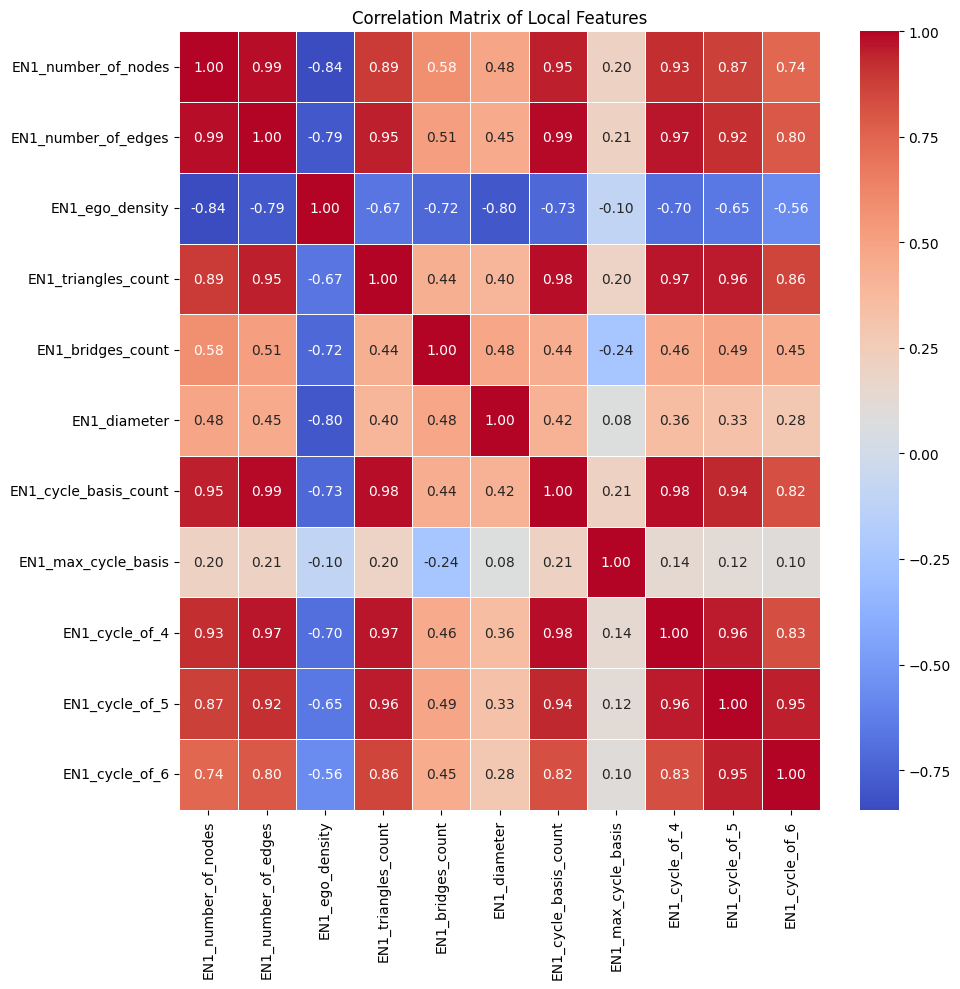

In [25]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 10))
sns.heatmap(df[en1_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Local Features')
plt.tight_layout()
plt.show()

In [9]:
# Importing seaborn library to plot correlation matrix
import seaborn as sns

<ipython-input-10-1b0aa9c96311>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)


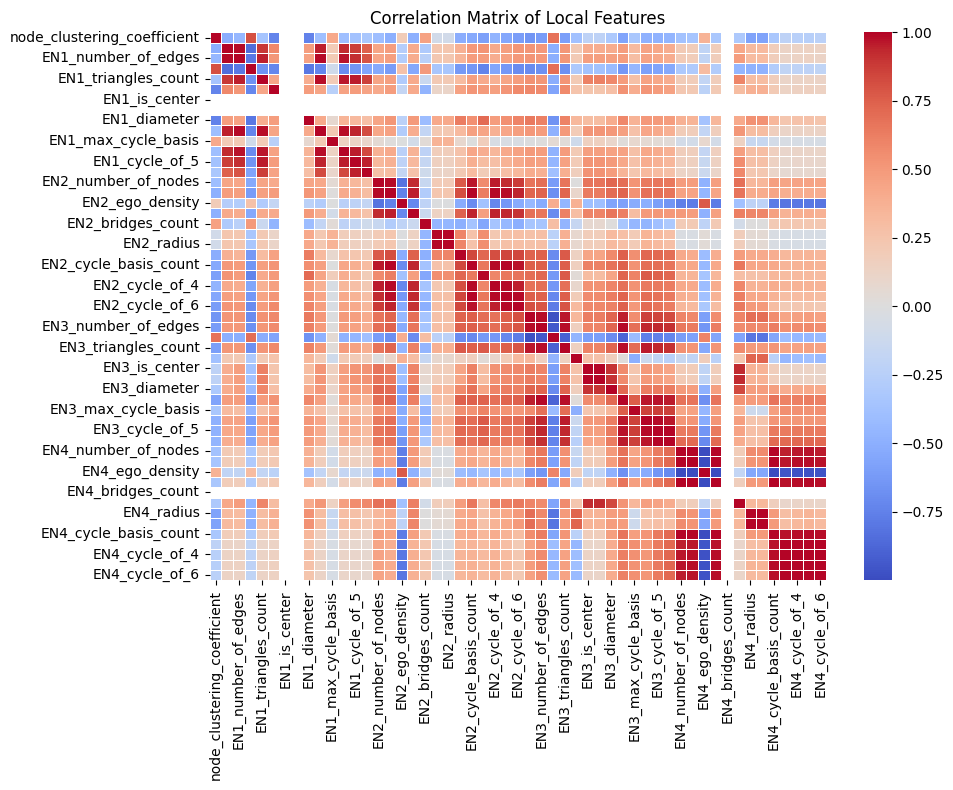

In [10]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Local Features')
plt.tight_layout()
plt.show()